<a href="https://colab.research.google.com/github/Eezzeldin/candy/blob/main/ATE_Candy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import make_scorer, balanced_accuracy_score


from sklearn.model_selection import RandomizedSearchCV, LeaveOneOut  , StratifiedKFold , cross_val_score , cross_val_predict
from scipy.stats import uniform , randint

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

In [60]:
data = pd.read_csv ("/content/candy-data.csv")
data

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,Welch's Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,Werther's Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


In [61]:
data.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   competitorname    85 non-null     object 
 1   chocolate         85 non-null     int64  
 2   fruity            85 non-null     int64  
 3   caramel           85 non-null     int64  
 4   peanutyalmondy    85 non-null     int64  
 5   nougat            85 non-null     int64  
 6   crispedricewafer  85 non-null     int64  
 7   hard              85 non-null     int64  
 8   bar               85 non-null     int64  
 9   pluribus          85 non-null     int64  
 10  sugarpercent      85 non-null     float64
 11  pricepercent      85 non-null     float64
 12  winpercent        85 non-null     float64
dtypes: float64(3), int64(9), object(1)
memory usage: 8.8+ KB


In [62]:
data.columns

Index(['competitorname', 'chocolate', 'fruity', 'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent',
       'pricepercent', 'winpercent'],
      dtype='object')

In [63]:
c1 = data ['chocolate'] == 0
c2 = data ['fruity'] == 0
c  = c1 & c2

data ["other_candy"] = np.where (c , 1 , 0)

In [64]:
data ["winpercent"] = data ["winpercent"] / 100

In [65]:
decision_cols = ['chocolate', 'fruity', 'other_candy' ,'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus']
cont_cols     = ['sugarpercent','winpercent' ,'pricepercent' ]

array([[<Axes: title={'center': 'chocolate'}>,
        <Axes: title={'center': 'fruity'}>,
        <Axes: title={'center': 'other_candy'}>],
       [<Axes: title={'center': 'caramel'}>,
        <Axes: title={'center': 'peanutyalmondy'}>,
        <Axes: title={'center': 'nougat'}>],
       [<Axes: title={'center': 'crispedricewafer'}>,
        <Axes: title={'center': 'hard'}>,
        <Axes: title={'center': 'bar'}>],
       [<Axes: title={'center': 'pluribus'}>, <Axes: >, <Axes: >]],
      dtype=object)

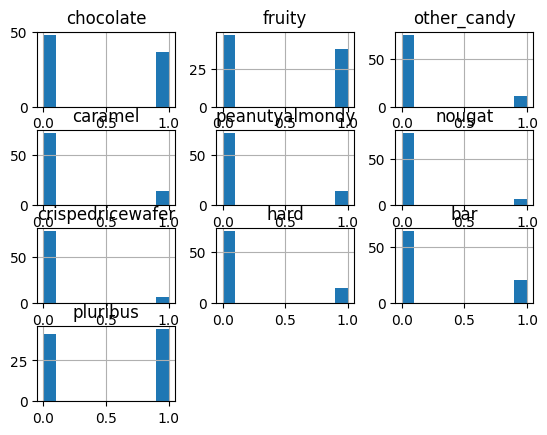

In [66]:
data [decision_cols].hist ()

In [67]:
data [decision_cols].nunique ()

chocolate           2
fruity              2
other_candy         2
caramel             2
peanutyalmondy      2
nougat              2
crispedricewafer    2
hard                2
bar                 2
pluribus            2
dtype: int64

In [68]:
#'caramel', 'peanutyalmondy', 'nougat', 'crispedricewafer', 'hard', 'pluribus'

df = data.copy (deep = True)

T = 'caramel'
W = 'winpercent'
X = [t for t in decision_cols if t not in [W , T , "bar"]]

df_Treatment_c = df [T] == 1
df_Control_c   = df [T] == 0
df_Treatment  = df [df_Treatment_c]
df_Control    = df [df_Control_c]

X_Treatment = pd.concat ( [df_Treatment [[T]],df_Treatment [X]] ,axis =1)
y_Treatment = df_Treatment [W]

X_Control  =  pd.concat ( [df_Control [[T]],df_Control [X]] ,axis =1)
y_Control  =  df_Control [W]

reg_Treatment        = RandomForestRegressor ()
reg_Control          = RandomForestRegressor ()

reg_Treatment.fit (X_Treatment,y_Treatment)
reg_Control.fit (X_Control,y_Control)

df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
df_Control   ["predictions"] = reg_Control.predict (X_Control)

ate   = df_Treatment ["predictions"].mean () - df_Control   ["predictions"].mean ()
ate

<ipython-input-68-a5b4a717073d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-68-a5b4a717073d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


0.08985201795340259

In [69]:
def get_ate_1 (data , T , W) :


    df = data.copy (deep = True)

    T = T
    W = W
    X = [t for t in decision_cols if t not in [W , T , "bar"]]

    df_Treatment_c = df [T] == 1
    df_Control_c   = df [T] == 0
    df_Treatment  = df [df_Treatment_c]
    df_Control    = df [df_Control_c]

    X_Treatment = pd.concat ( [df_Treatment [[T]],df_Treatment [X]] ,axis =1)
    y_Treatment = df_Treatment [W]

    X_Control  =  pd.concat ( [df_Control [[T]],df_Control [X]] ,axis =1)
    y_Control  =  df_Control [W]

    reg_Treatment        = RandomForestRegressor ()
    reg_Control          = RandomForestRegressor ()

    reg_Treatment.fit (X_Treatment,y_Treatment)
    reg_Control.fit (X_Control,y_Control)

    df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
    df_Control   ["predictions"] = reg_Control.predict (X_Control)

    ate   = df_Treatment ["predictions"].mean () - df_Control   ["predictions"].mean ()
    return ate

In [70]:
T = 'caramel'
W = 'winpercent'
get_ate_1 (data , T , W)

<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


0.08542045760240713

In [71]:
W_dict = {"winpercent" : [] , "pricepercent" :[] , "sugarpercent" :[]}
T_list = ['chocolate','caramel', 'peanutyalmondy', 'nougat', 'crispedricewafer', 'hard', 'pluribus']

In [72]:
for W in W_dict.keys() :
    W_ate_list = []
    for T in T_list:
        ate = get_ate_1 (data , T , W)
        W_ate_list.append (ate)
        W_dict [W] = W_ate_list
        print (W,T,ate)

<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent chocolate 0.18720503586535447


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent caramel 0.08756021289505345


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent peanutyalmondy 0.1717956613017701


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent nougat 0.11073198030857939


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent crispedricewafer 0.18465396190608063


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent hard -0.1242704325860644


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent pluribus -0.06762880065632793


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent chocolate 0.2905801599271627


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent caramel 0.1982198310743717


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent peanutyalmondy 0.23263781876860773


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent nougat 0.15118415482792302


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent crispedricewafer 0.3528490227938825


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent hard -0.1748483802025404


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent pluribus -0.12899237429229493


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


sugarpercent chocolate 0.0584534608623441


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


sugarpercent caramel 0.2002391616881199


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


sugarpercent peanutyalmondy 0.0824151823299048


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


sugarpercent nougat 0.12718070281256422


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


sugarpercent crispedricewafer 0.031095841203224728


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


sugarpercent hard 0.08349962285153079
sugarpercent pluribus 0.024897629908272656


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


In [73]:
W_dict

{'winpercent': [0.18720503586535447,
  0.08756021289505345,
  0.1717956613017701,
  0.11073198030857939,
  0.18465396190608063,
  -0.1242704325860644,
  -0.06762880065632793],
 'pricepercent': [0.2905801599271627,
  0.1982198310743717,
  0.23263781876860773,
  0.15118415482792302,
  0.3528490227938825,
  -0.1748483802025404,
  -0.12899237429229493],
 'sugarpercent': [0.0584534608623441,
  0.2002391616881199,
  0.0824151823299048,
  0.12718070281256422,
  0.031095841203224728,
  0.08349962285153079,
  0.024897629908272656]}

In [74]:
pd.DataFrame (W_dict)

,winpercent,pricepercent,sugarpercent
0,0.187205,0.290580,0.058453
1,0.087560,0.198220,0.200239
2,0.171796,0.232638,0.082415
3,0.110732,0.151184,0.127181
4,0.184654,0.352849,0.031096
5,-0.124270,-0.174848,0.083500
6,-0.067629,-0.128992,0.024898


In [75]:
T_list

['chocolate',
 'caramel',
 'peanutyalmondy',
 'nougat',
 'crispedricewafer',
 'hard',
 'pluribus']

In [76]:
ate_df                = pd.DataFrame (W_dict)
ate_df ["treatments"] = T_list
ate_df.set_index ("treatments")

,winpercent,pricepercent,sugarpercent
treatments,,,
chocolate,0.187205,0.290580,0.058453
caramel,0.087560,0.198220,0.200239
peanutyalmondy,0.171796,0.232638,0.082415
nougat,0.110732,0.151184,0.127181
crispedricewafer,0.184654,0.352849,0.031096
hard,-0.124270,-0.174848,0.083500
pluribus,-0.067629,-0.128992,0.024898


In [77]:
#ate_df.to_csv ("ate_df.csv")

In [78]:
def get_ate_fruity (data , T , W) :


    df = data.copy (deep = True)

    T = T
    W = W
    X = [t for t in decision_cols if t not in [W , T , "chocolate" , "other_candy"]]

    df_Treatment_c = df [T] == 1
    df_Control_c   = df [T] == 0
    df_Treatment  = df [df_Treatment_c]
    df_Control    = df [df_Control_c]

    X_Treatment = pd.concat ( [df_Treatment [[T]],df_Treatment [X]] ,axis =1)
    y_Treatment = df_Treatment [W]

    X_Control  =  pd.concat ( [df_Control [[T]],df_Control [X]] ,axis =1)
    y_Control  =  df_Control [W]

    reg_Treatment        = RandomForestRegressor ()
    reg_Control          = RandomForestRegressor ()

    reg_Treatment.fit (X_Treatment,y_Treatment)
    reg_Control.fit (X_Control,y_Control)

    df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
    df_Control   ["predictions"] = reg_Control.predict (X_Control)

    ate   = df_Treatment ["predictions"].mean () - df_Control   ["predictions"].mean ()
    return ate

In [80]:
for W in W_dict.keys() :
    for T in ["fruity"]:
        ate = get_ate_fruity (data , T , W)
        W_dict [W].append (ate)
        print (W,T,ate)

<ipython-input-78-b5bda42a8276>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-78-b5bda42a8276>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent fruity -0.11257157567193826


<ipython-input-78-b5bda42a8276>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-78-b5bda42a8276>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent fruity -0.2442714692119431
sugarpercent fruity -0.012241969535750907


<ipython-input-78-b5bda42a8276>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-78-b5bda42a8276>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


In [81]:
def get_ate_other (data , T , W) :


    df = data.copy (deep = True)

    T = T
    W = W
    X = [t for t in decision_cols if t not in [W , T , "chocolate" , "fruity"]]

    df_Treatment_c = df [T] == 1
    df_Control_c   = df [T] == 0
    df_Treatment  = df [df_Treatment_c]
    df_Control    = df [df_Control_c]

    X_Treatment = pd.concat ( [df_Treatment [[T]],df_Treatment [X]] ,axis =1)
    y_Treatment = df_Treatment [W]

    X_Control  =  pd.concat ( [df_Control [[T]],df_Control [X]] ,axis =1)
    y_Control  =  df_Control [W]

    reg_Treatment        = RandomForestRegressor ()
    reg_Control          = RandomForestRegressor ()

    reg_Treatment.fit (X_Treatment,y_Treatment)
    reg_Control.fit (X_Control,y_Control)

    df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
    df_Control   ["predictions"] = reg_Control.predict (X_Control)

    ate   = df_Treatment ["predictions"].mean () - df_Control   ["predictions"].mean ()
    return ate

In [82]:
for W in W_dict.keys() :
    for T in ["other_candy"]:
        ate = get_ate_other (data , T , W)
        W_dict [W].append (ate)
        print (W,T,ate)

<ipython-input-81-187743091b87>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-81-187743091b87>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent other_candy -0.16197033881638367


<ipython-input-81-187743091b87>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-81-187743091b87>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent other_candy -0.12438658822493298
sugarpercent other_candy -0.08891127205146904


<ipython-input-81-187743091b87>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-81-187743091b87>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


In [84]:
ate_df                = pd.DataFrame (W_dict)
ate_df ["treatments"] = ['chocolate',  'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'pluribus' , 'fruity', 'other_candy']
ate_df.set_index ("treatments")

,winpercent,pricepercent,sugarpercent
treatments,,,
chocolate,0.187205,0.290580,0.058453
caramel,0.087560,0.198220,0.200239
peanutyalmondy,0.171796,0.232638,0.082415
nougat,0.110732,0.151184,0.127181
crispedricewafer,0.184654,0.352849,0.031096
hard,-0.124270,-0.174848,0.083500
pluribus,-0.067629,-0.128992,0.024898
fruity,-0.112572,-0.244271,-0.012242
other_candy,-0.161970,-0.124387,-0.088911


In [86]:
ate_df.to_csv ("ate_df_xyz123.csv")

In [105]:
from scipy.optimize import linprog
import numpy as np

candy_data = data.copy (deep = True)

# Extract the decision variables
num_candies = len(candy_data)
decision_vars = ['chocolate', 'fruity', 'caramel', 'peanutyalmondy', 'nougat', 'crispedricewafer', 'hard', 'pluribus']

# Objective function coefficients (negated to convert to minimization problem)
objective = -candy_data['winpercent'].to_numpy()

# Constraints coefficients for sugarpercent and pricepercent
A = np.vstack([candy_data['sugarpercent'], candy_data['pricepercent']])
b = np.array([5, 5])

# Bounds for each variable (binary: 0 or 1)
bounds = [(0, 1) for _ in range(num_candies)]

# Solve the linear programming problem
result = linprog(objective, A_ub=A, b_ub=b, bounds=bounds, method='highs')

# Extract the optimal candy selection
optimal_candies = [candy_data.iloc[i]['competitorname'] for i in range(num_candies) if result.x[i] == 1]

optimal_candies, -result.fun


(['One dime',
  'One quarter',
  'Fruit Chews',
  "Hershey's Kisses",
  'Junior Mints',
  'Kit Kat',
  'Laffy Taffy',
  'Lemonhead',
  'Lifesavers big ring gummies',
  'Now & Later',
  'Pixie Sticks',
  "Reese's Miniatures",
  'Sixlets',
  'Smarties candy',
  'Sour Patch Kids',
  'Sour Patch Tricksters',
  'Starburst',
  'Strawberry bon bons',
  'Super Bubble',
  'Tootsie Roll Midgies',
  'Trolli Sour Bites',
  'Twizzlers',
  'Warheads',
  "Welch's Fruit Snacks",
  "Werther's Original Caramel"],
 12.318314259532817)

In [106]:
c = candy_data ['competitorname'].isin (optimal_candies)
candy_data [c]

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,other_candy
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,0.322611,1
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,0.461165,1
15,Fruit Chews,0,1,0,0,0,0,0,0,1,0.127,0.034,0.430889,0
22,Hershey's Kisses,1,0,0,0,0,0,0,0,1,0.127,0.093,0.553755,0
27,Junior Mints,1,0,0,0,0,0,0,0,1,0.197,0.511,0.572192,0
28,Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,0.767686,0
29,Laffy Taffy,0,1,0,0,0,0,0,0,0,0.220,0.116,0.413896,0
30,Lemonhead,0,1,0,0,0,0,1,0,0,0.046,0.104,0.391411,0
31,Lifesavers big ring gummies,0,1,0,0,0,0,0,0,0,0.267,0.279,0.529114,0
45,Now & Later,0,1,0,0,0,0,0,0,1,0.220,0.325,0.394468,0


In [107]:
candy_data [c] ["sugarpercent"].sum ()

4.471999942

In [98]:
c = candy_data ['competitorname'].isin (optimal_candies)
candy_data [~c]

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,other_candy
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,0.669717,0
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,0.676029,0
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,0.461165,1
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,0.523415,0
5,Almond Joy,1,0,0,1,0,0,0,1,0,0.465,0.767,0.503475,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,Trolli Sour Bites,0,1,0,0,0,0,0,0,1,0.313,0.255,0.471732,0
79,Twix,1,0,1,0,0,1,0,1,0,0.546,0.906,0.816429,0
82,Welch's Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,0.443755,0
83,Werther's Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,0.419043,1


<Axes: >

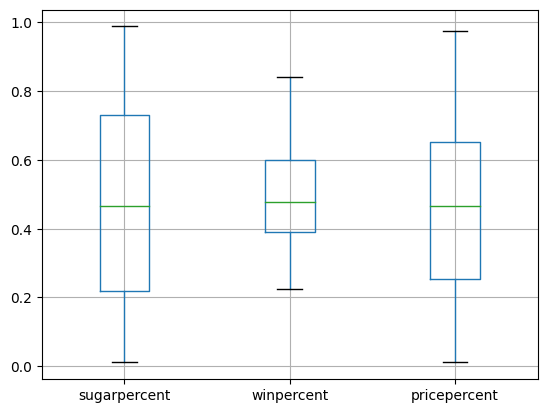

In [93]:
candy_data [cont_cols].boxplot()

In [111]:
from scipy.optimize import linprog
import numpy as np

candy_data = data.copy (deep = True)

# Extract the decision variables
num_candies = len(candy_data)
decision_vars = ['chocolate', 'fruity', 'caramel', 'peanutyalmondy', 'nougat', 'crispedricewafer', 'hard', 'pluribus']

# Objective function coefficients (negated to convert to minimization problem)
objective = -candy_data['winpercent'].to_numpy()

# Constraints coefficients for sugarpercent and pricepercent
A = np.vstack([candy_data['sugarpercent'], candy_data['pricepercent']])

sugarpercent_list = []
pricepercent_list = []
winpercent_list   = []
for i in range (1,50):
  for j in range (1,50):

    b = np.array([i/10, j/10])
    sugarpercent_list.append (i/10)
    pricepercent_list.append (j/10)
    # Bounds for each variable (binary: 0 or 1)
    bounds = [(0, 1) for _ in range(num_candies)]

    # Solve the linear programming problem
    result = linprog(objective, A_ub=A, b_ub=b, bounds=bounds, method='highs')

    # Extract the optimal candy selection
    optimal_candies = [candy_data.iloc[i]['competitorname'] for i in range(num_candies) if result.x[i] == 1]

    optimal_candies, -result.fun
    winpercent_list .append (-result.fun)

    print (i/10,j/10,-result.fun)


0.1 0.1 0.6481284281048763
0.1 0.2 0.9164202468231293
0.1 0.3 1.1679999091521562
0.1 0.4 1.4146743177546157
0.1 0.5 1.627759463760044
0.1 0.6 1.7020182094015852
0.1 0.7 1.7762769550431263
0.1 0.8 1.8505357006846677
0.1 0.9 1.9247944463262088
0.1 1.0 1.9841799102348248
0.1 1.1 1.9841799102348248
0.1 1.2 1.9841799102348248
0.1 1.3 1.9841799102348248
0.1 1.4 1.9841799102348248
0.1 1.5 1.9841799102348248
0.1 1.6 1.9841799102348248
0.1 1.7 1.9841799102348248
0.1 1.8 1.9841799102348248
0.1 1.9 1.9841799102348248
0.1 2.0 1.9841799102348248
0.1 2.1 1.9841799102348248
0.1 2.2 1.9841799102348248
0.1 2.3 1.9841799102348248
0.1 2.4 1.9841799102348248
0.1 2.5 1.9841799102348248
0.1 2.6 1.9841799102348248
0.1 2.7 1.9841799102348248
0.1 2.8 1.9841799102348248
0.1 2.9 1.9841799102348248
0.1 3.0 1.9841799102348248
0.1 3.1 1.9841799102348248
0.1 3.2 1.9841799102348248
0.1 3.3 1.9841799102348248
0.1 3.4 1.9841799102348248
0.1 3.5 1.9841799102348248
0.1 3.6 1.9841799102348248
0.1 3.7 1.9841799102348248
0.

In [112]:
sim_dict = {
    "sugarpercent_sim"  : sugarpercent_list ,
    "pricepercent_sim"  : pricepercent_list ,
    "winpercent_sim"    : winpercent_list

}

In [114]:
sim_df = pd.DataFrame (sim_dict)
sim_df

,sugarpercent_sim,pricepercent_sim,winpercent_sim
0,0.1,0.1,0.648128
1,0.1,0.2,0.916420
2,0.1,0.3,1.168000
3,0.1,0.4,1.414674
4,0.1,0.5,1.627759
...,...,...,...
2396,4.9,4.5,11.840668
2397,4.9,4.6,11.928431
2398,4.9,4.7,12.016070
2399,4.9,4.8,12.103709


<Axes: xlabel='sugarpercent_sim', ylabel='pricepercent_sim'>

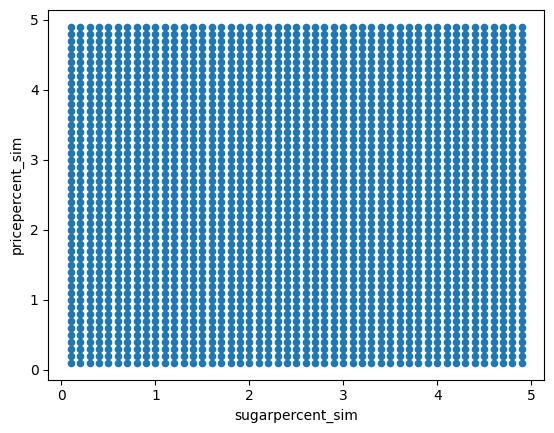

In [117]:
sim_df.plot.scatter ("sugarpercent_sim" , "pricepercent_sim")

<Axes: xlabel='sugarpercent_sim', ylabel='winpercent_sim'>

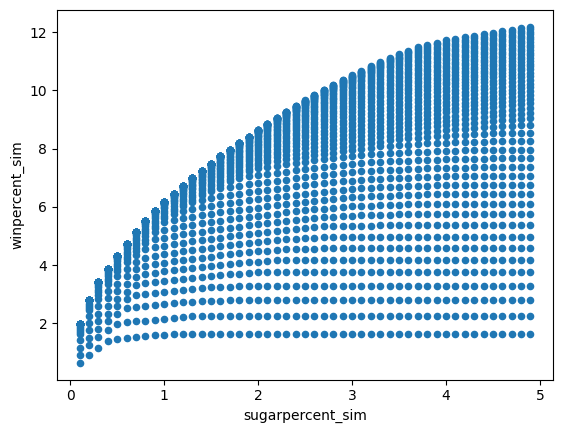

In [115]:
sim_df.plot.scatter ("sugarpercent_sim" , "winpercent_sim")

<Axes: xlabel='pricepercent_sim', ylabel='winpercent_sim'>

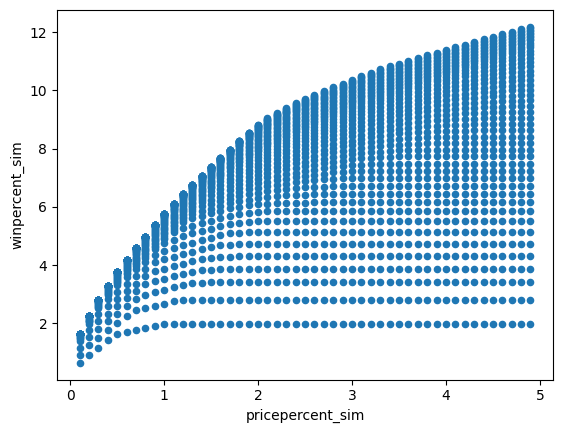

In [116]:
sim_df.plot.scatter ("pricepercent_sim" , "winpercent_sim")

<Axes: xlabel='winpercent_sim', ylabel='pricepercent_sim'>

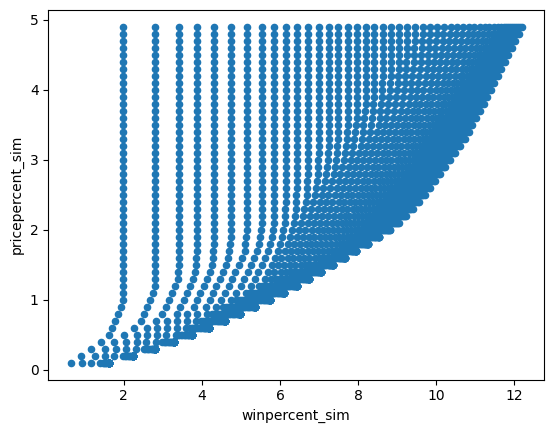

In [118]:
sim_df.plot.scatter ( "winpercent_sim" , "pricepercent_sim")

In [ ]:
sim_df ["pricepercent_sim" * [""]]

In [119]:
sim_df.to_csv ("sim_df_xyz123.csv")

In [ ]:
from scipy.optimize import linprog
import numpy as np

candy_data = data.copy (deep = True)

# Extract the decision variables
num_candies = len(candy_data)
decision_vars = ['chocolate', 'fruity', 'caramel', 'peanutyalmondy', 'nougat', 'crispedricewafer', 'hard', 'pluribus']

# Objective function coefficients (negated to convert to minimization problem)
objective = -candy_data['winpercent'].to_numpy()

# Constraints coefficients for sugarpercent and pricepercent
A = np.vstack([candy_data['sugarpercent'], candy_data['pricepercent']])
b = np.array([5, 5])

# Bounds for each variable (binary: 0 or 1)
bounds = [(0, 1) for _ in range(num_candies)]

# Solve the linear programming problem
result = linprog(objective, A_ub=A, b_ub=b, bounds=bounds, method='highs')

# Extract the optimal candy selection
optimal_candies = [candy_data.iloc[i]['competitorname'] for i in range(num_candies) if result.x[i] == 1]

optimal_candies, -result.fun
